# Teoría de Colas

## Librerías

In [1]:
import pandas as pd
import numpy as np
from simpy.core import Environment
from simpy.resources.resource import Resource
import matplotlib.pyplot as plt

## Desarrollo Computacional

In [2]:
def queue_simulation(
    arrival_mean: float,  # Tiempo entre llegadas (segundos)
    attention_mean: float,  # Tiempo de atención (segundos)
    servers_count: int,  # Número de servidores
    simulation_time_total: float,  # Tiempo total de la simulación (horas)
    dataset: dict[int, dict[str, int | float]],
):
    env = Environment()
    servers = Resource(env, capacity=servers_count)

    env.process(
        request_arrival(env, servers, arrival_mean / 60, attention_mean / 60, dataset)
    )
    env.run(until=simulation_time_total * 60)


def request_arrival(
    env: Environment,
    servers: Resource,
    arrival_mean: float,  # Tiempo entre llegadas (minutos)
    attention_mean: float,  # Tiempo de atención (minutos)
    dataset: dict[int, dict[str, int | float]],
):
    request_id = 0
    last_arrival_time = 0
    while True:
        # Tiempo de espera para que llegue una nueva petición
        yield env.timeout(np.random.exponential(scale=arrival_mean))
        request_id += 1
        current_arrival_time = env.now
        waiting_time = current_arrival_time - last_arrival_time
        last_arrival_time = current_arrival_time
        env.process(
            request_attention(
                env, servers, attention_mean, request_id, waiting_time, dataset
            )
        )


def request_attention(
    env: Environment,
    servers: Resource,
    attention_mean: float,
    request_id: int,
    waiting_time: float,
    dataset: dict[int, dict[str, int | float]],
):
    with servers.request() as request:
        dataset[request_id] = {}
        dataset[request_id]["arrival_times"] = env.now
        dataset[request_id]["waiting_times"] = waiting_time

        # Ingresa la petición a la cola y la saca cuando
        # #se encuentre un servidor disponible
        yield request
        dataset[request_id]["start_times"] = env.now

        # Atención de la petición
        yield env.timeout(np.random.poisson(lam=attention_mean))
        dataset[request_id]["end_times"] = env.now
        dataset[request_id]["attention_durations"] = (
            dataset[request_id]["end_times"] - dataset[request_id]["start_times"]
        )

In [3]:
def create_data_frame(dataset: dict[int, dict[str, int | float]]) -> pd.DataFrame:
    sorted_dataset = sorted(dataset.items())

    data = {
        "Petición": [key for key, _ in sorted_dataset],
        "Tiempo Llegada": [
            value.get("arrival_times", None) for _, value in sorted_dataset
        ],
        "Tiempo Espera": [
            value.get("waiting_times", None) for _, value in sorted_dataset
        ],
        "Tiempo Inicio": [
            value.get("start_times", None) for _, value in sorted_dataset
        ],
        "Tiempo Fin": [value.get("end_times", None) for _, value in sorted_dataset],
        "Duración Atención": [
            value.get("attention_durations", None) for _, value in sorted_dataset
        ],
    }

    df = pd.DataFrame(data)
    df = df.round(4)  # Redondear a 4 decimales
    return df

In [4]:
def plot_arrival_time_and_end_time(data: pd.DataFrame):
    plt.plot(data["Tiempo Llegada"], data["Petición"], label="Llegadas")
    plt.plot(data["Tiempo Fin"], data["Petición"], label="Finalizaciones")
    plt.xlabel("Tiempo")
    plt.ylabel("Número de Peticiones")
    plt.title("Línea de Tiempo de Llegadas y Finalizaciones")
    plt.legend()
    plt.show()


def plot_waiting_time_versus_attention_duration(data: pd.DataFrame):
    plt.scatter(data["Tiempo Espera"], data["Duración Atención"])
    plt.xlabel("Tiempo de Espera")
    plt.ylabel("Duración de Atención")
    plt.title("Tiempo de Espera vs Duración de Atención")
    plt.show()

## Ejercicio 1

In [5]:
dataset = {}
queue_simulation(3, 4, 5, 3, dataset)
data = create_data_frame(dataset)

data

,Petición,Tiempo Llegada,Tiempo Espera,Tiempo Inicio,Tiempo Fin,Duración Atención
0,1,0.0781,0.0781,0.0781,1.0781,1.0
1,2,0.1442,0.0662,0.1442,0.1442,0.0
2,3,0.2203,0.0761,0.2203,0.2203,0.0
3,4,0.2290,0.0087,0.2290,0.2290,0.0
4,5,0.2972,0.0681,0.2972,0.2972,0.0
...,...,...,...,...,...,...
3537,3538,179.6589,0.0163,179.6589,179.6589,0.0
3538,3539,179.8109,0.1520,179.8109,179.8109,0.0
3539,3540,179.8318,0.0209,179.8318,179.8318,0.0
3540,3541,179.9279,0.0961,179.9279,179.9279,0.0


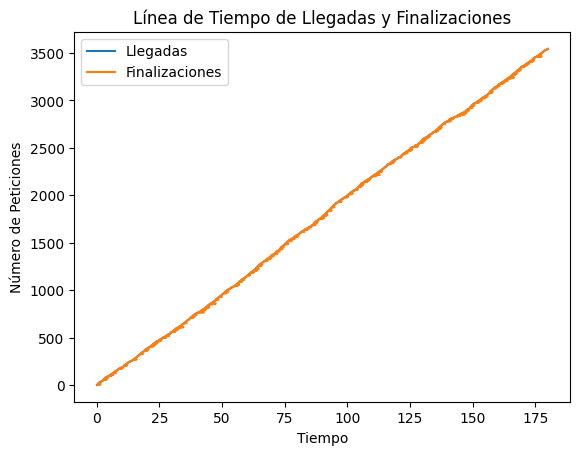

In [6]:
plot_arrival_time_and_end_time(data)

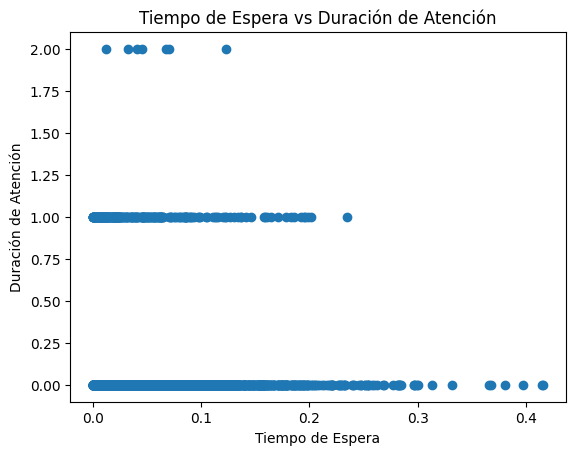

In [7]:
plot_waiting_time_versus_attention_duration(data)

## Ejercicio 2

In [8]:
dataset = {}
queue_simulation(3, 4, 10, 3, dataset)
data = create_data_frame(dataset)

data

,Petición,Tiempo Llegada,Tiempo Espera,Tiempo Inicio,Tiempo Fin,Duración Atención
0,1,0.0072,0.0072,0.0072,0.0072,0.0
1,2,0.0501,0.0429,0.0501,0.0501,0.0
2,3,0.1362,0.0861,0.1362,0.1362,0.0
3,4,0.1443,0.0081,0.1443,0.1443,0.0
4,5,0.1480,0.0037,0.1480,0.1480,0.0
...,...,...,...,...,...,...
3642,3643,179.6697,0.0879,179.6697,179.6697,0.0
3643,3644,179.7918,0.1221,179.7918,179.7918,0.0
3644,3645,179.8944,0.1026,179.8944,179.8944,0.0
3645,3646,179.9686,0.0742,179.9686,179.9686,0.0


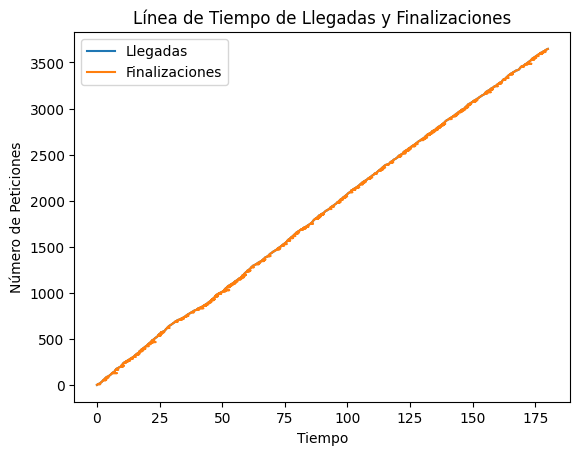

In [9]:
plot_arrival_time_and_end_time(data)

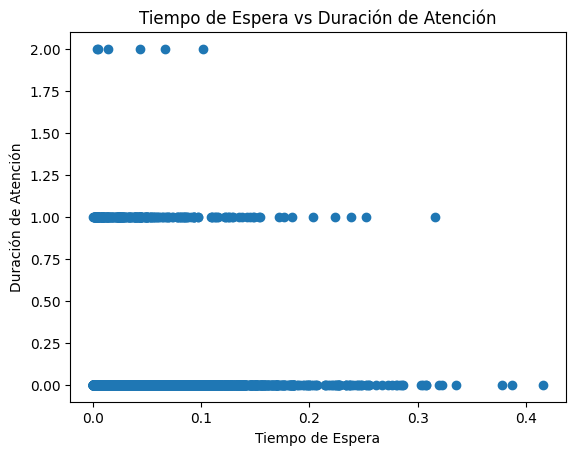

In [10]:
plot_waiting_time_versus_attention_duration(data)

## Ejercicio Dinámico

     Petición  Tiempo Llegada  Tiempo Espera  Tiempo Inicio  Tiempo Fin  \
0           1          0.6005         0.6005         0.6005      0.6005   
1           2          1.1813         0.5808         1.1813      1.1813   
2           3          1.2563         0.0750         1.2563      2.2563   
3           4          1.7843         0.5280         2.2563      2.2563   
4           5          2.0589         0.2746         2.2563      3.2563   
..        ...             ...            ...            ...         ...   
101       102         57.0650         0.0860        57.9691     57.9691   
102       103         57.1392         0.0742        57.9691     57.9691   
103       104         57.7125         0.5733        57.9691     57.9691   
104       105         58.4387         0.7262        58.4387     59.4387   
105       106         59.1848         0.7461        59.4387     59.4387   

     Duración Atención  
0                  0.0  
1                  0.0  
2                  1.0  

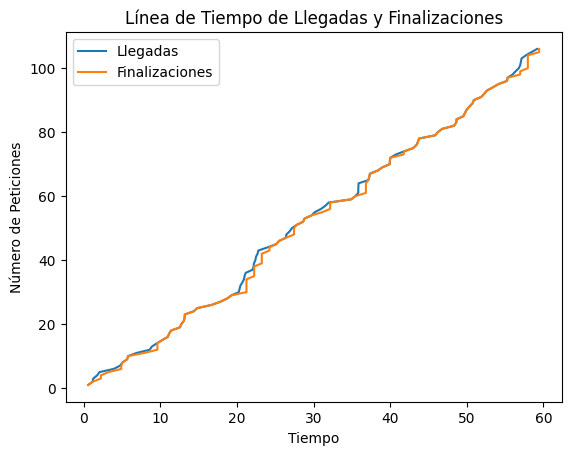

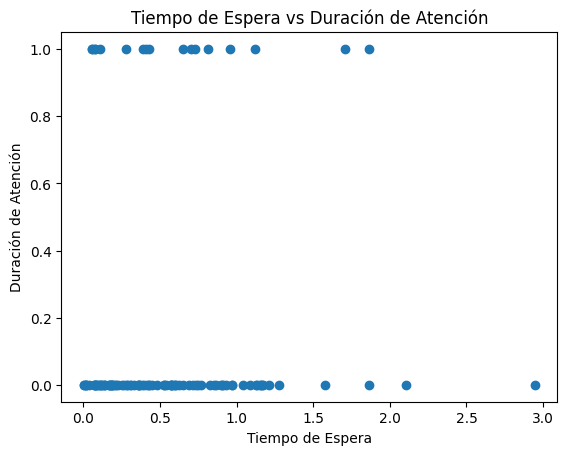

In [11]:
arrival_mean = float(input("Tiempo medio entre llegadas (segundos): "))
attention_mean = float(input("Tiempo medio de atención (segundos): "))
servers_count = int(input("Número de servidores: "))
simulation_time_total = float(input("Tiempo total de la simulación (horas): "))

dataset = {}
queue_simulation(
    arrival_mean, attention_mean, servers_count, simulation_time_total, dataset
)
data = create_data_frame(dataset)

print(data)

plot_arrival_time_and_end_time(data)
plot_waiting_time_versus_attention_duration(data)